# 0. 패키지 불러오기

In [ ]:
!pip install catboost
!pip install category_encoders
!pip install optuna
!pip install kmodes

In [ ]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm # matplotlib의 font_manager에서 폰트설정을 변경하여 matplotlib에서도 한글 출력을 가능하게 한다.
import seaborn as sns

from sklearn.ensemble import * # ExtraTreesRegressor, RandomForestClassifier
from sklearn.model_selection import * # KFold, cross_val_score, train_test_split
from sklearn.metrics import *  # make_scorer : MSE 대신 사용자가 정의한 손실함수를 사용하고 싶을 때
from sklearn.preprocessing import * # LabelEncoder, StandardScaler
from sklearn.svm import * # SVC, SVR
from sklearn.inspection import *
from sklearn.linear_model import * # LogisticRegression, RANSACRegressor, Ridge, Lasso, ElasticNet
from sklearn.decomposition import * # PCA

from category_encoders.ordinal import OrdinalEncoder
from catboost import CatBoostClassifier, Pool
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

from lightgbm import *
import lightgbm as lgb
import xgboost as xgb
from datetime import datetime
import calendar
import warnings
warnings.filterwarnings(action = 'ignore') # 경고메세지를 무시하거나 숨긴다.

# 1. 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/공모전/잡케어/RawData"

 속성_D_코드.csv	    submission_cat.csv	 'train2_수정 전.csv'
 속성_H_코드.csv	    submission_lgbm.csv   train2.csv
 속성_L_코드.csv	   'test2_수정 전.csv'	  train.csv
 참가자_제공_레이아웃.pdf   test2.csv
 sample_submission.csv	    test.csv


In [ ]:
Rdata_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/공모전/잡케어/RawData/train2.csv')
Rdata_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/공모전/잡케어/RawData/test2.csv')
Rdata_D = pd.read_csv('/content/drive/My Drive/Colab Notebooks/공모전/잡케어/RawData/속성_D_코드.csv', index_col = 0).T.to_dict()
Rdata_H = pd.read_csv('/content/drive/My Drive/Colab Notebooks/공모전/잡케어/RawData/속성_H_코드.csv', index_col = 0).T.to_dict()
Rdata_L = pd.read_csv('/content/drive/My Drive/Colab Notebooks/공모전/잡케어/RawData/속성_L_코드.csv', index_col = 0).T.to_dict()
print(Rdata_train.shape)
print(Rdata_train.size)
print(Rdata_test.shape)
print(Rdata_test.size)
Rdata_train.head()

(501951, 97)
48689247
(46404, 96)
4454784


,Unnamed: 0,id,person_attribute_a,person_attribute_a_under,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_f,person_prefer_g,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_under,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,target,person_prefer_d_1_세,person_prefer_d_1_소,person_prefer_d_1_중,person_prefer_d_1_대,person_prefer_d_2_세,person_prefer_d_2_소,person_prefer_d_2_중,person_prefer_d_2_대,person_prefer_d_3_세,person_prefer_d_3_소,person_prefer_d_3_중,...,d1_la_match_yn,d1_mi_match_yn,d1_sm_match_yn,d1_sub_match_yn,d1_all_match_yn,d2_la_match_yn,d2_mi_match_yn,d2_sm_match_yn,d2_sub_match_yn,d2_all_match_yn,d3_la_match_yn,d3_mi_match_yn,d3_sm_match_yn,d3_sub_match_yn,d3_all_match_yn,h1_la_match_yn,h1_mi_match_yn,h1_all_match_yn,h2_la_match_yn,h2_mi_match_yn,h2_all_match_yn,h3_la_match_yn,h3_mi_match_yn,h3_all_match_yn,Year,Month,Day,dayofweek,Hour,Minute,Second,dayofyear,season,Hour2,d1_match,d2_match,d3_match,h1_match,h2_match,h3_match
0,0,0,1,4,3,5,275,370,369,8,1,1,4,95,59,3,3,10,2,1,2,1608,275,1,4,139,618822,354805,1,275,274,274,216,369,368,297,216,369,368,297,...,True,True,True,True,True,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,2020,1,17,4,12,9,36,17,winter,afternoon,TTTTT,TFFFF,TFFFF,FFF,TFF,FFF
1,1,1,1,3,4,1,114,181,175,4,1,1,131,101,96,1,3,5,1,1,2,1608,275,1,4,133,571659,346213,0,114,109,56,1,175,152,56,1,175,152,56,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,True,False,False,2020,6,18,3,17,48,52,170,summer,afternoon,FFFFF,FFFFF,FFFFF,TTF,TFF,TFF
2,2,2,2,0,3,5,464,175,452,3,1,1,54,263,56,3,1,10,2,1,1,1600,94,1,4,53,399816,206408,0,464,463,450,377,175,152,56,1,452,451,450,...,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,2020,7,8,2,20,0,10,190,summer,night,FFFFF,TTFFF,FFFFF,TFF,FFF,TFF
3,3,3,2,0,2,5,703,705,704,3,1,1,72,227,2,1,3,5,1,1,2,1608,275,5,3,74,827967,572323,0,703,703,690,618,703,703,690,618,703,703,690,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,2020,1,13,0,18,9,34,13,winter,night,FFFFF,FFFFF,FFFFF,TFF,FFF,FFF
4,4,4,1,3,4,5,275,370,369,4,1,1,214,210,209,1,1,10,2,1,2,1608,275,1,4,74,831614,573899,0,275,274,274,216,369,368,297,216,369,368,297,...,True,True,True,True,True,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,2020,3,9,0,20,39,22,69,spring,night,TTTTT,TFFFF,TFFFF,FFF,FFF,FFF


In [ ]:
df_train = Rdata_train.copy()
df_test = Rdata_test.copy()
df_D = Rdata_D.copy()
df_H = Rdata_H.copy()
df_L = Rdata_L.copy()

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501951 entries, 0 to 501950
Data columns (total 97 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Unnamed: 0                  501951 non-null  int64 
 1   id                          501951 non-null  int64 
 2   person_attribute_a          501951 non-null  int64 
 3   person_attribute_a_under    501951 non-null  int64 
 4   person_attribute_b          501951 non-null  int64 
 5   person_prefer_c             501951 non-null  int64 
 6   person_prefer_d_1           501951 non-null  int64 
 7   person_prefer_d_2           501951 non-null  int64 
 8   person_prefer_d_3           501951 non-null  int64 
 9   person_prefer_e             501951 non-null  int64 
 10  person_prefer_f             501951 non-null  int64 
 11  person_prefer_g             501951 non-null  int64 
 12  person_prefer_h_1           501951 non-null  int64 
 13  person_prefer_h_2           5

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46404 entries, 0 to 46403
Data columns (total 96 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Unnamed: 0                  46404 non-null  int64 
 1   id                          46404 non-null  int64 
 2   person_attribute_a          46404 non-null  int64 
 3   person_attribute_a_under    46404 non-null  int64 
 4   person_attribute_b          46404 non-null  int64 
 5   person_prefer_c             46404 non-null  int64 
 6   person_prefer_d_1           46404 non-null  int64 
 7   person_prefer_d_2           46404 non-null  int64 
 8   person_prefer_d_3           46404 non-null  int64 
 9   person_prefer_e             46404 non-null  int64 
 10  person_prefer_f             46404 non-null  int64 
 11  person_prefer_g             46404 non-null  int64 
 12  person_prefer_h_1           46404 non-null  int64 
 13  person_prefer_h_2           46404 non-null  in

# 2. 범주형 encoding

In [ ]:
df_train.dtypes.value_counts()

int64     65
bool      24
object     8
dtype: int64

int형에 속하는 컬럼들에 특징 값 분포
*   특징 값 분포를 통해서 Label Encoding과 Ont-Hot Encoding 방식을 결정
*   가장 많은 특징 값을 갖는 것이 'person_rn' -> 300177


*   동일한 특징 값을 갖는 특징들은 ['person_prefer_f', 'person_prefer_g', 'Y'] 라는 것을 파악 ->  이 변수들은 볼 필요가 없다.
  *   모든 값에 대해서 동일한 값을 갖는 것을 주목해야 한다.
  *   이러한 특징 값들은 추후 모델 학습에서 Drop 시키고 학습을 실시 하겠습니다.

Ont-Hot Encoding
1. 순서가 없을 때 (ex. 국가명)
2. 고유값의 개수가 많지 않으면 효율적

Label Encoding
1. 순서의 의미가 있을때 (유치원, 초등학교, 대학교 같은 등급, 사원, 대리, 과장, 부장 같은 직급?? )
2. 고유값의 개수가 많을때 (One-hot Encoding은 당연히 메모리 소비가 많으므로 효율적이진 못하다. )
3. 선형 회귀와 같은 ML알고리즘에는 적용 불가
4. 트리 계열의 ML 알고리즘은 숫자의 이러한 특성을 반영하지 않으므로 가능
5. LabelEncoder는 dataframe의 열마다 접근해야 한다.

In [ ]:
df_train.select_dtypes('int64').apply(pd.Series.nunique, axis = 0)[df_train.select_dtypes('int64').apply(pd.Series.nunique, axis = 0) == 1]

person_prefer_f    1
person_prefer_g    1
Year               1
dtype: int64

In [ ]:
df_train.columns

Index(['Unnamed: 0', 'id', 'person_attribute_a', 'person_attribute_a_under',
       'person_attribute_b', 'person_prefer_c', 'person_prefer_d_1',
       'person_prefer_d_2', 'person_prefer_d_3', 'person_prefer_e',
       'person_prefer_f', 'person_prefer_g', 'person_prefer_h_1',
       'person_prefer_h_2', 'person_prefer_h_3', 'contents_attribute_i',
       'contents_attribute_a', 'contents_attribute_j_under',
       'contents_attribute_j', 'contents_attribute_c', 'contents_attribute_k',
       'contents_attribute_l', 'contents_attribute_d', 'contents_attribute_m',
       'contents_attribute_e', 'contents_attribute_h', 'person_rn',
       'contents_rn', 'target', 'person_prefer_d_1_세', 'person_prefer_d_1_소',
       'person_prefer_d_1_중', 'person_prefer_d_1_대', 'person_prefer_d_2_세',
       'person_prefer_d_2_소', 'person_prefer_d_2_중', 'person_prefer_d_2_대',
       'person_prefer_d_3_세', 'person_prefer_d_3_소', 'person_prefer_d_3_중',
       'person_prefer_d_3_대', 'contents_attribute_d_세'

In [ ]:
for column in df_train.select_dtypes(include = 'bool').columns :
    df_train[column] = df_train[column].astype(int)
    
for column in df_test.select_dtypes(include = 'bool').columns :
    df_test[column] = df_test[column].astype(int)

In [ ]:
df_train2 = df_train.drop(['person_prefer_f', 'person_prefer_g', 'Year', 'Unnamed: 0', 'id'], axis = 1)
df_test2 = df_test.drop(['person_prefer_f', 'person_prefer_g', 'Year', 'Unnamed: 0', 'id'], axis = 1)
print(df_train2.shape)
print(df_test2.shape)

(501951, 92)
(46404, 91)


In [ ]:
df_train2.dtypes.value_counts()

int64     84
object     8
dtype: int64

In [ ]:
df_train2.select_dtypes(include = 'object').columns

Index(['season', 'Hour2', 'd1_match', 'd2_match', 'd3_match', 'h1_match',
       'h2_match', 'h3_match'],
      dtype='object')

In [ ]:
df_train2.columns

Index(['person_attribute_a', 'person_attribute_a_under', 'person_attribute_b',
       'person_prefer_c', 'person_prefer_d_1', 'person_prefer_d_2',
       'person_prefer_d_3', 'person_prefer_e', 'person_prefer_h_1',
       'person_prefer_h_2', 'person_prefer_h_3', 'contents_attribute_i',
       'contents_attribute_a', 'contents_attribute_j_under',
       'contents_attribute_j', 'contents_attribute_c', 'contents_attribute_k',
       'contents_attribute_l', 'contents_attribute_d', 'contents_attribute_m',
       'contents_attribute_e', 'contents_attribute_h', 'person_rn',
       'contents_rn', 'target', 'person_prefer_d_1_세', 'person_prefer_d_1_소',
       'person_prefer_d_1_중', 'person_prefer_d_1_대', 'person_prefer_d_2_세',
       'person_prefer_d_2_소', 'person_prefer_d_2_중', 'person_prefer_d_2_대',
       'person_prefer_d_3_세', 'person_prefer_d_3_소', 'person_prefer_d_3_중',
       'person_prefer_d_3_대', 'contents_attribute_d_세',
       'contents_attribute_d_소', 'contents_attribute_d_중',
    

In [ ]:
numerical_feats = ['Month', 'Day', 'dayofweek', 'Hour', 'Minute', 'Second', 'dayofyear']

ordinal_feats = ['person_attribute_a_under', 'person_attribute_b', 'person_prefer_e', 'contents_attribute_e']

categorical_feats_oe =  ['person_prefer_d_1', 'person_prefer_d_2', 'person_prefer_d_3',
                        'person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3', 'contents_attribute_l',
                        'contents_attribute_d', 'contents_attribute_h', 'person_rn', 'contents_rn', 
                        'person_prefer_d_1_세', 'person_prefer_d_1_소', 'person_prefer_d_1_중',
                        'person_prefer_d_1_대', 'person_prefer_d_2_세', 'person_prefer_d_2_소',
                        'person_prefer_d_2_중', 'person_prefer_d_2_대', 'person_prefer_d_3_세',
                        'person_prefer_d_3_소', 'person_prefer_d_3_중', 'person_prefer_d_3_대',
                        'contents_attribute_d_세', 'contents_attribute_d_소',
                        'contents_attribute_d_중', 'contents_attribute_d_대',
                        'person_prefer_h_1_중', 'person_prefer_h_1_대', 'person_prefer_h_2_중',
                        'person_prefer_h_2_대', 'person_prefer_h_3_중', 'person_prefer_h_3_대',
                        'contents_attribute_h_중', 'contents_attribute_h_대',
                        'contents_attribute_l_세', 'contents_attribute_l_소',
                        'contents_attribute_l_중', 'contents_attribute_l_대']

print("Number of numerical_feats : ", len(numerical_feats))
print("Number of ordinal_feats : ", len(ordinal_feats))
print("Number of categorical_feats_oe : ", len(categorical_feats_oe))

Number of numerical_feats :  7
Number of ordinal_feats :  4
Number of categorical_feats_oe :  39


In [ ]:
temp = numerical_feats + ordinal_feats + categorical_feats_oe
categorical_feats_gd_ohe = df_train2.columns[~df_train2.columns.isin(temp)]
categorical_feats_gd_ohe = pd.DataFrame(categorical_feats_gd_ohe)
categorical_feats_gd_ohe = categorical_feats_gd_ohe.loc[categorical_feats_gd_ohe[0] != 'target', :]
categorical_feats_gd_ohe = categorical_feats_gd_ohe[0]
categorical_feats_gd_ohe = categorical_feats_gd_ohe.values.tolist()
print("Number of categorical_feats_gd_ohe : ", len(categorical_feats_gd_ohe))

categorical_feats_gd = ['season', 'Hour2', 'd1_match', 'd2_match', 'd3_match', 'h1_match', 'h2_match', 'h3_match']
categorical_feats_ohe = categorical_feats_gd_ohe.copy()
for obj in categorical_feats_gd :
  categorical_feats_ohe.remove(obj)

print("Number of categorical_feats_gd : ", len(categorical_feats_gd))
print("Number of categorical_feats_ohe : ", len(categorical_feats_ohe))

Number of categorical_feats_gd_ohe :  41
Number of categorical_feats_gd :  8
Number of categorical_feats_ohe :  33


In [ ]:
categorical_feats_gd

['season',
 'Hour2',
 'd1_match',
 'd2_match',
 'd3_match',
 'h1_match',
 'h2_match',
 'h3_match']

In [ ]:
categorical_feats_ohe

['person_attribute_a',
 'person_prefer_c',
 'contents_attribute_i',
 'contents_attribute_a',
 'contents_attribute_j_under',
 'contents_attribute_j',
 'contents_attribute_c',
 'contents_attribute_k',
 'contents_attribute_m',
 'd1_la_match_yn',
 'd1_mi_match_yn',
 'd1_sm_match_yn',
 'd1_sub_match_yn',
 'd1_all_match_yn',
 'd2_la_match_yn',
 'd2_mi_match_yn',
 'd2_sm_match_yn',
 'd2_sub_match_yn',
 'd2_all_match_yn',
 'd3_la_match_yn',
 'd3_mi_match_yn',
 'd3_sm_match_yn',
 'd3_sub_match_yn',
 'd3_all_match_yn',
 'h1_la_match_yn',
 'h1_mi_match_yn',
 'h1_all_match_yn',
 'h2_la_match_yn',
 'h2_mi_match_yn',
 'h2_all_match_yn',
 'h3_la_match_yn',
 'h3_mi_match_yn',
 'h3_all_match_yn']

In [ ]:
categorical_feats_oe

['person_prefer_d_1',
 'person_prefer_d_2',
 'person_prefer_d_3',
 'person_prefer_h_1',
 'person_prefer_h_2',
 'person_prefer_h_3',
 'contents_attribute_l',
 'contents_attribute_d',
 'contents_attribute_h',
 'person_rn',
 'contents_rn',
 'person_prefer_d_1_세',
 'person_prefer_d_1_소',
 'person_prefer_d_1_중',
 'person_prefer_d_1_대',
 'person_prefer_d_2_세',
 'person_prefer_d_2_소',
 'person_prefer_d_2_중',
 'person_prefer_d_2_대',
 'person_prefer_d_3_세',
 'person_prefer_d_3_소',
 'person_prefer_d_3_중',
 'person_prefer_d_3_대',
 'contents_attribute_d_세',
 'contents_attribute_d_소',
 'contents_attribute_d_중',
 'contents_attribute_d_대',
 'person_prefer_h_1_중',
 'person_prefer_h_1_대',
 'person_prefer_h_2_중',
 'person_prefer_h_2_대',
 'person_prefer_h_3_중',
 'person_prefer_h_3_대',
 'contents_attribute_h_중',
 'contents_attribute_h_대',
 'contents_attribute_l_세',
 'contents_attribute_l_소',
 'contents_attribute_l_중',
 'contents_attribute_l_대']

In [ ]:
numerical_feats

['Month', 'Day', 'dayofweek', 'Hour', 'Minute', 'Second', 'dayofyear']

In [ ]:
# OrdinalEncoder

oe = OrdinalEncoder(categorical_feats_gd)
df_train2[categorical_feats_gd] = oe.fit_transform(df_train2[categorical_feats_gd], df_train2['target'])
df_test2[categorical_feats_gd] = oe.transform(df_test2[categorical_feats_gd])

df_train2[categorical_feats_gd] = df_train2[categorical_feats_gd].astype('int64')
df_test2[categorical_feats_gd] = df_test2[categorical_feats_gd].astype('int64')

In [ ]:
df_train2.head()

,person_attribute_a,person_attribute_a_under,person_attribute_b,person_prefer_c,person_prefer_d_1,person_prefer_d_2,person_prefer_d_3,person_prefer_e,person_prefer_h_1,person_prefer_h_2,person_prefer_h_3,contents_attribute_i,contents_attribute_a,contents_attribute_j_under,contents_attribute_j,contents_attribute_c,contents_attribute_k,contents_attribute_l,contents_attribute_d,contents_attribute_m,contents_attribute_e,contents_attribute_h,person_rn,contents_rn,target,person_prefer_d_1_세,person_prefer_d_1_소,person_prefer_d_1_중,person_prefer_d_1_대,person_prefer_d_2_세,person_prefer_d_2_소,person_prefer_d_2_중,person_prefer_d_2_대,person_prefer_d_3_세,person_prefer_d_3_소,person_prefer_d_3_중,person_prefer_d_3_대,contents_attribute_d_세,contents_attribute_d_소,contents_attribute_d_중,...,contents_attribute_l_대,d1_la_match_yn,d1_mi_match_yn,d1_sm_match_yn,d1_sub_match_yn,d1_all_match_yn,d2_la_match_yn,d2_mi_match_yn,d2_sm_match_yn,d2_sub_match_yn,d2_all_match_yn,d3_la_match_yn,d3_mi_match_yn,d3_sm_match_yn,d3_sub_match_yn,d3_all_match_yn,h1_la_match_yn,h1_mi_match_yn,h1_all_match_yn,h2_la_match_yn,h2_mi_match_yn,h2_all_match_yn,h3_la_match_yn,h3_mi_match_yn,h3_all_match_yn,Month,Day,dayofweek,Hour,Minute,Second,dayofyear,season,Hour2,d1_match,d2_match,d3_match,h1_match,h2_match,h3_match
0,1,4,3,5,275,370,369,8,4,95,59,3,3,10,2,1,2,1608,275,1,4,139,618822,354805,1,275,274,274,216,369,368,297,216,369,368,297,216,275,274,274,...,2016,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,17,4,12,9,36,17,1,1,1,1,1,1,1,1
1,1,3,4,1,114,181,175,4,131,101,96,1,3,5,1,1,2,1608,275,1,4,133,571659,346213,0,114,109,56,1,175,152,56,1,175,152,56,1,275,274,274,...,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,6,18,3,17,48,52,170,2,1,2,2,2,2,1,2
2,2,0,3,5,464,175,452,3,54,263,56,3,1,10,2,1,1,1600,94,1,4,53,399816,206408,0,464,463,450,377,175,152,56,1,452,451,450,377,92,91,56,...,2016,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,7,8,2,20,0,10,190,2,2,2,3,2,3,2,2
3,2,0,2,5,703,705,704,3,72,227,2,1,3,5,1,1,2,1608,275,5,3,74,827967,572323,0,703,703,690,618,703,703,690,618,703,703,690,618,275,274,274,...,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,13,0,18,9,34,13,1,2,2,2,2,3,2,1
4,1,3,4,5,275,370,369,4,214,210,209,1,1,10,2,1,2,1608,275,1,4,74,831614,573899,0,275,274,274,216,369,368,297,216,369,368,297,216,275,274,274,...,2016,1,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,9,0,20,39,22,69,3,2,1,1,1,1,2,1


In [ ]:
print(df_train2.dtypes.value_counts())
print(df_test2.dtypes.value_counts())

int64    92
dtype: int64
int64    91
dtype: int64


In [ ]:
###################################################################################################################
# 여기서부터

# a = pd.get_dummies(df_train2[categorical_feats_gd])
# df_train3 = pd.concat([df_train2, a], axis = 1)
# for obj in categorical_feats_gd :
#     df_train3 = df_train3.drop(obj, axis = 1)
    
# print(df_train3.shape)

# b = pd.get_dummies(df_test2[categorical_feats_gd])
# df_test3 = pd.concat([df_test2, b], axis = 1)
# for obj in categorical_feats_gd :
#     df_test3 = df_test3.drop(obj, axis = 1)

# df_test3['season_fall'] = 0
# df_test3['season_spring'] = 0
# df_test3['season_summer'] = 0

# print(df_test3.shape)
###################################################################################################################

In [ ]:
# df_train3.dtypes.value_counts()

In [ ]:
###################################################################################################################
# One Hot Enconding

# ohe = OneHotEncoder()

# c = ohe.fit_transform(df_train3[categorical_feats_ohe]).toarray()
# d = ohe.transform(df_test3[categorical_feats_ohe]).toarray()

# ohe_columns = ohe.get_feature_names(categorical_feats_ohe)
# cc = pd.DataFrame(c, columns = ohe_columns)
# dd = pd.DataFrame(d, columns = ohe_columns)
# print(cc.shape)
# print(dd.shape)


# df_train4 = pd.concat([df_train3, cc], axis = 1)
# for obj in categorical_feats_ohe :
#     df_train4 = df_train4.drop(obj, axis = 1)

# print(len(categorical_feats_ohe))
# print(df_train3.shape)
# print(df_train4.shape)

# df_test4 = pd.concat([df_test3, dd], axis = 1)
# for obj in categorical_feats_ohe :
 #    df_test4 = df_test4.drop(obj, axis = 1)

# print(len(categorical_feats_ohe))
# print(df_test3.shape)
# print(df_test4.shape)
###################################################################################################################

In [ ]:
###################################################################################################################
# 숫자 -> 문자

# df_train4[categorical_feats_oe] = df_train4[categorical_feats_oe].astype(str)
# print(df_train4.dtypes)

# df_test4[categorical_feats_oe] = df_test4[categorical_feats_oe].astype(str)
# print(df_test4.dtypes)
###################################################################################################################

In [ ]:
###################################################################################################################
# OrdinalEncoder

# oe = OrdinalEncoder(categorical_feats_oe)
# df_train4[categorical_feats_oe] = oe.fit_transform(df_train4[categorical_feats_oe], df_train4['target'])
# df_test4[categorical_feats_oe] = oe.transform(df_test4[categorical_feats_oe])

# df_train4['person_rn'] = df_train4['person_rn'].astype('int64')
# df_train4['contents_rn'] = df_train4['contents_rn'].astype('int64')
# df_test4['person_rn'] = df_test4['person_rn'].astype('int64')
# df_test4['contents_rn'] = df_test4['contents_rn'].astype('int64')
###################################################################################################################

In [ ]:
df_train3 = df_train2.copy()
df_test3 = df_test2.copy()

# 3. 모델 비교 (randomforest, xgboost, lightgbm, extratree)

In [ ]:
def tscv(model) :

    tscv_list = []
    model_name = model.__class__.__name__

    for i in range(1, 11) :

      df_train5_1 = df_train4.loc[df_train4['Month'] <= i, :]
      X_train = df_train5_1.drop('target', axis = 1)
      y_train = df_train5_1['target']
      df_train5_2 = df_train4.loc[df_train4['Month'] == i + 1]
      X_test = df_train5_2.drop('target', axis = 1)
      y_test = df_train5_2['target']

      clf = model.fit(X_train, y_train)
      pred = clf.predict(X_test)
      f1 = f1_score(y_test, pred) 
      tscv_list.append(f1)
      print(model_name, i)

    return model_name, tscv_list

In [ ]:
def print_f1_score(model) :
    # cv별 프린팅, 평균 저장
    model_name, score = tscv(model)

    for i, r in enumerate(score, start = 1) :
        print(f'{i} FOLDS: {model_name} f1 : {r:.4f}')
    print(f'\n{model_name} mean f1 : {np.mean(score):.4f}')
    print('=' * 40)
    return model_name, np.mean(score)

In [ ]:
rf = RandomForestClassifier(n_estimators = 500, max_depth = 9, min_samples_split = 50, min_samples_leaf = 5, random_state = 39, n_jobs = -1)
model_xgb = xgb.XGBClassifier(n_estimators = 500, max_depth = 9, min_child_weight = 5, gamma = 0.1, n_jobs = -1)
model_lgb = lgb.LGBMClassifier(n_estimators = 500, max_depth = 9, min_child_weight = 5, n_jobs = -1)
etc = ExtraTreesClassifier(n_estimators = 500, max_depth = 9, min_samples_split = 50, min_samples_leaf = 5, random_state = 39, n_jobs = -1)

In [ ]:
models = []
scores = []

# [rf, model_xgb, model_lgb, etc]

for model in [rf, model_xgb, model_lgb, etc] :
    model_name, mean_score = print_f1_score(model)
    models.append(model_name)
    scores.append(mean_score)

RandomForestClassifier 1
RandomForestClassifier 2
RandomForestClassifier 3
RandomForestClassifier 4
RandomForestClassifier 5
RandomForestClassifier 6
RandomForestClassifier 7
RandomForestClassifier 8
RandomForestClassifier 9
1 FOLDS: RandomForestClassifier f1 : 0.6005
2 FOLDS: RandomForestClassifier f1 : 0.6071
3 FOLDS: RandomForestClassifier f1 : 0.6094
4 FOLDS: RandomForestClassifier f1 : 0.6202
5 FOLDS: RandomForestClassifier f1 : 0.6199
6 FOLDS: RandomForestClassifier f1 : 0.6229
7 FOLDS: RandomForestClassifier f1 : 0.6271
8 FOLDS: RandomForestClassifier f1 : 0.6254
9 FOLDS: RandomForestClassifier f1 : 0.6246

RandomForestClassifier mean f1 : 0.6174
XGBClassifier 1
XGBClassifier 2
XGBClassifier 3
XGBClassifier 4
XGBClassifier 5
XGBClassifier 6
XGBClassifier 7
XGBClassifier 8
XGBClassifier 9
1 FOLDS: XGBClassifier f1 : 0.5936
2 FOLDS: XGBClassifier f1 : 0.6042
3 FOLDS: XGBClassifier f1 : 0.6248
4 FOLDS: XGBClassifier f1 : 0.6299
5 FOLDS: XGBClassifier f1 : 0.6406
6 FOLDS: XGBClassif

In [ ]:
result_df = pd.DataFrame({'Model' : models, 'Score' : scores}).reset_index(drop = True)
result_df

,Model,Score
0,RandomForestClassifier,0.617440
1,XGBClassifier,0.626772
2,LGBMClassifier,0.634342
3,ExtraTreesClassifier,0.604991


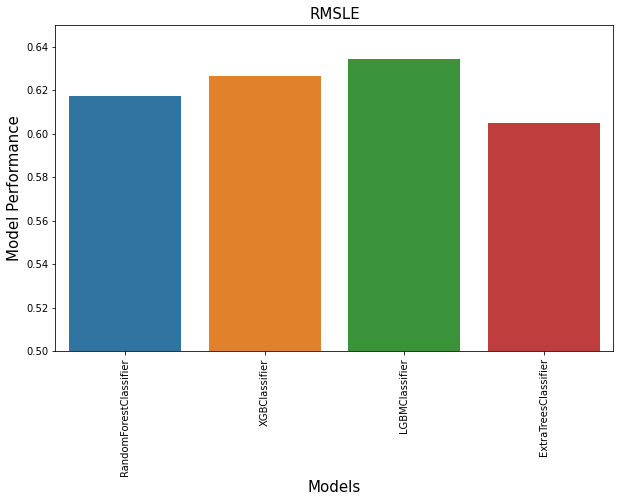

In [ ]:
f, ax = plt.subplots(figsize = (10, 6))
plt.xticks(rotation = '90')
sns.barplot(x = result_df['Model'], y = result_df['Score'])
plt.xlabel('Models', fontsize = 15)
plt.ylabel('Model Performance', fontsize = 15)
plt.ylim(0.5, 0.65)
plt.title('RMSLE', fontsize = 15)
plt.show()

# 4-1. 클러스터링, 표준화 및 데이터 분할

In [ ]:
def elbow(X) :
  distortions = []
  for i in range(1, 21) :
    km = KMeans(n_clusters = i, random_state = 39, n_init = 10, max_iter = 300)
    km.fit(X)
    distortions.append(km.inertia_)

  plt.plot(range(11, 21), distortions, marker = 'o')
  plt.xlabel('Number of clusters')
  plt.ylabel('SSE(k)')
  plt.show()

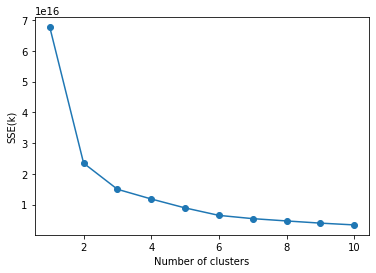

In [ ]:
kmeans_train = df_train3.drop(['target'], axis = 1)

elbow(kmeans_train)

# 7로 결정

In [ ]:
# 클러스터링 구성
# 타겟을 결정짓는 뚜렷한 특징을 갖는 피쳐를 찾지 못해 clustering 시도

kmeans_train = df_train3.drop(['target'], axis = 1)
kmeans = KMeans(n_clusters = 7, init = 'k-means++', n_init = 10, max_iter = 300, tol = 1e-04, random_state = 39).fit(kmeans_train)
df_train3['cluster'] = kmeans.predict(kmeans_train)
df_test3['cluster'] = kmeans.predict(df_test3)

In [ ]:
df_train3['cluster'] = df_train3['cluster'].astype('int64')
df_test3['cluster'] = df_test3['cluster'].astype('int64')

df_train3.dtypes.value_counts()

int64    93
dtype: int64

In [ ]:
df_train4 = df_train3.copy()
df_test4 = df_test3.copy()

In [ ]:
# StandardScale
# 컬럼 정규화

temp_columns2 = numerical_feats
scaler = StandardScaler()
df_train4[temp_columns2] = scaler.fit_transform(df_train4[temp_columns2])
df_test4[temp_columns2] = scaler.transform(df_test4[temp_columns2])

In [ ]:
print(df_train4.dtypes.value_counts())
print(df_test4.dtypes.value_counts())

int64      86
float64     7
dtype: int64
int64      85
float64     7
dtype: int64


In [ ]:
numerical_feats

['Month', 'Day', 'dayofweek', 'Hour', 'Minute', 'Second', 'dayofyear']

In [ ]:
# temp_columns = df_train4.dtypes[df_train4.dtypes != "int64"].index.tolist()

# temp_columns3 = []
# for i in temp_columns :
#   if i not in numerical_feats :
#     temp_columns3.append(i)

# for col in temp_columns3 :
#   df_train4[col] = df_train4[col].astype('int64')
#   df_test4[col] = df_test4[col].astype('int64')

In [ ]:
# print(df_train4.dtypes.value_counts())
# print(df_test4.dtypes.value_counts())

int64      86
float64     5
dtype: int64
int64      85
float64     5
dtype: int64


In [ ]:
sorted(df_train4['Month'].unique())

[-1.553057947212434,
 -1.238148108969224,
 -0.9232382707260137,
 -0.6083284324828035,
 -0.2934185942395934,
 0.021491244003616763,
 0.3364010822468269,
 0.651310920490037,
 0.9662207587332472,
 1.2811305969764575,
 1.5960404352196675]

In [ ]:
df_train6_1 = df_train4.loc[df_train4['Month'] < 0.7, :]
df_train6_1.reset_index(drop = True, inplace = True)
X_part_train = df_train6_1.drop('target', axis = 1)
y_part_train = df_train6_1['target']

df_train6_2 = df_train4.loc[(df_train4['Month'] > 0.7) & (df_train4['Month'] < 1.4)]
df_train6_2.reset_index(drop = True, inplace = True)
X_val = df_train6_2.drop('target', axis = 1)
y_val = df_train6_2['target']

df_train6_3 = df_train4.loc[df_train4['Month']> 1.4]
df_train6_3.reset_index(drop = True, inplace = True)
X_part_test = df_train6_3.drop('target', axis = 1)
y_part_test = df_train6_3['target']

df_train6_4 = df_train4.loc[df_train4['Month'] < 1.4]
df_train6_4.reset_index(drop = True, inplace = True)
X_train = df_train6_4.drop('target', axis = 1)
y_train = df_train6_4['target']

X_test = df_test4.copy()

print(X_part_train.shape)
print(y_part_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_part_test.shape)
print(y_part_test.shape)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(368974, 92)
(368974,)
(87998, 92)
(87998,)
(44979, 92)
(44979,)
(456972, 92)
(456972,)
(46404, 92)


In [ ]:
tt1 = X_train.columns.tolist() 
tt2 = numerical_feats
print(len(tt1))
print(len(tt2))
tt3 = []
for i in tt1 :
  if i not in tt2 :
    tt3.append(i)
print(len(tt3))
print(tt3)

cat_cols = tt3

92
7
85
['person_attribute_a', 'person_attribute_a_under', 'person_attribute_b', 'person_prefer_c', 'person_prefer_d_1', 'person_prefer_d_2', 'person_prefer_d_3', 'person_prefer_e', 'person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3', 'contents_attribute_i', 'contents_attribute_a', 'contents_attribute_j_under', 'contents_attribute_j', 'contents_attribute_c', 'contents_attribute_k', 'contents_attribute_l', 'contents_attribute_d', 'contents_attribute_m', 'contents_attribute_e', 'contents_attribute_h', 'person_rn', 'contents_rn', 'person_prefer_d_1_세', 'person_prefer_d_1_소', 'person_prefer_d_1_중', 'person_prefer_d_1_대', 'person_prefer_d_2_세', 'person_prefer_d_2_소', 'person_prefer_d_2_중', 'person_prefer_d_2_대', 'person_prefer_d_3_세', 'person_prefer_d_3_소', 'person_prefer_d_3_중', 'person_prefer_d_3_대', 'contents_attribute_d_세', 'contents_attribute_d_소', 'contents_attribute_d_중', 'contents_attribute_d_대', 'person_prefer_h_1_중', 'person_prefer_h_1_대', 'person_prefer_h_2_중', 'person_

In [ ]:
temp = X_part_train.columns[X_part_train.nunique() > 2].tolist()
temp2 = set(temp)
cat_cols2 = set(cat_cols)
cat_cols3 = list(temp2 & cat_cols2)
print(len(cat_cols3))

58


# 4-2. 모델링 1

In [ ]:
def objective(trial : Trial) -> float :

    params_cat = {
        "random_state" : 39,
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 30.00),
        "n_estimators":trial.suggest_int("n_estimators", 3000, 7000),
        "max_depth":trial.suggest_int("max_depth", 4, 16),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': 'Iter',
        'one_hot_max_size' : trial.suggest_int('one_hot_max_size', 0, 5)
  }
    
    model = CatBoostClassifier(**params_cat, task_type = "GPU")
    model.fit(X_part_train, y_part_train, eval_set = [(X_val, y_val)],
              early_stopping_rounds = 50, cat_features = cat_cols3, verbose = False)

    cat_pred = model.predict(X_val)
    f1 = f1_score(y_val, cat_pred)
    
    return f1

In [ ]:
sampler = TPESampler(seed = 39)
study = optuna.create_study(
    study_name = "cat_parameter_opt",
    direction = "maximize",
    sampler = sampler)
study.optimize(objective, n_trials = 40)

[I 2022-01-13 09:07:31,493] A new study created in memory with name: cat_parameter_opt
[I 2022-01-13 09:14:49,201] Trial 0 finished with value: 0.6474524150363183 and parameters: {'learning_rate': 0.06424237623635748, 'bagging_temperature': 15.545191810637657, 'n_estimators': 4120, 'max_depth': 5, 'random_strength': 60, 'l2_leaf_reg': 1.5770182355103866e-05, 'min_child_samples': 49, 'max_bin': 341, 'od_type': 'Iter', 'one_hot_max_size': 4}. Best is trial 0 with value: 0.6474524150363183.
[I 2022-01-13 09:15:05,782] Trial 1 finished with value: 0.2005980190618576 and parameters: {'learning_rate': 0.2483447516200999, 'bagging_temperature': 47.68047444864912, 'n_estimators': 2133, 'max_depth': 14, 'random_strength': 95, 'l2_leaf_reg': 1.884510113652923e-05, 'min_child_samples': 29, 'max_bin': 378, 'od_type': 'IncToDec', 'one_hot_max_size': 5}. Best is trial 0 with value: 0.6474524150363183.
[I 2022-01-13 09:16:32,901] Trial 2 finished with value: 0.6029912698233663 and parameters: {'learn

In [ ]:
print("Best Score :", study.best_value)
print("Best trial :", study.best_trial.params)

Best Score : 0.6481461898014002
Best trial : {'learning_rate': 0.028920017036357652, 'bagging_temperature': 9.575922941873582, 'n_estimators': 4505, 'max_depth': 8, 'random_strength': 66, 'l2_leaf_reg': 2.164293737475176e-05, 'min_child_samples': 77, 'max_bin': 326, 'od_type': 'Iter', 'one_hot_max_size': 4}


In [ ]:
# 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# 파라미터들과의 관계
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna_cat = CatBoostClassifier(
    random_state = 39,
    learning_rate = study.best_trial.params['learning_rate'],
    n_estimators = study.best_trial.params['n_estimators'],
    max_depth = study.best_trial.params['max_depth'],
    bagging_temperature = study.best_trial.params['bagging_temperature'],
    random_strength = study.best_trial.params['random_strength'],
    max_bin = study.best_trial.params['max_bin'],
    od_type = 'Iter',
    one_hot_max_size = study.best_trial.params['one_hot_max_size'],
    task_type = "GPU")

optuna_cat.fit(X_train, y_train, verbose = False, cat_features = cat_cols3)
optuna_cat_train_preds = optuna_cat.predict(X_train)
optuna_cat_part_test_preds = optuna_cat.predict(X_part_test)
f1_train = f1_score(optuna_cat_train_preds, y_train)
f1_part_test = f1_score(optuna_cat_part_test_preds, y_part_test)
print('f1_train :', f1_train)
print('f1_part_test :', f1_part_test)


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

f1_train : 0.7439766098860169
f1_part_test : 0.6302331191473497


In [ ]:
threshold = 0.35

In [ ]:
pred_list = []
scores = []

pred = optuna_cat.predict_proba(X_test)[:, 1]
pred = np.where(pred >= threshold , 1, 0)

In [ ]:
# 제출

submission_preds = pred
submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/공모전/잡케어/RawData/sample_submission.csv')
submission['target'] = submission_preds
submission.to_csv('/content/drive/My Drive/Colab Notebooks/공모전/잡케어/RawData/submission_cat.csv', index = False)

# 5. 모델링 2

In [ ]:
best_trial_params = {'learning_rate': 0.028920017036357652, 'bagging_temperature': 9.575922941873582, 'n_estimators': 4505, 
                           'max_depth': 8, 'random_strength': 66, 'l2_leaf_reg': 2.164293737475176e-05, 'min_child_samples': 77, 
                           'max_bin': 326, 'od_type': 'Iter', 'one_hot_max_size': 4}

In [ ]:
optuna_cat2 = CatBoostClassifier(
    random_state = 39,
    learning_rate = best_trial_params['learning_rate'],
    n_estimators = best_trial_params['n_estimators'],
    max_depth = best_trial_params['max_depth'],
    bagging_temperature = best_trial_params['bagging_temperature'],
    random_strength = best_trial_params['random_strength'],
    max_bin = best_trial_params['max_bin'],
    od_type = 'Iter',
    one_hot_max_size = best_trial_params['one_hot_max_size'],
    task_type = "GPU")

optuna_cat2.fit(X_train, y_train, verbose = False, cat_features = cat_cols3)
optuna_cat2_train_preds = optuna_cat2.predict(X_train)
optuna_cat2_part_test_preds = optuna_cat2.predict(X_part_test)


In [ ]:
f1_train2 = f1_score(optuna_cat2_train_preds, y_train)
f1_part_test2 = f1_score(optuna_cat2_part_test_preds, y_part_test)
print('f1_train2 :', f1_train2)
print('f1_part_test2 :', f1_part_test2)

# 이전 f1_train : 0.7439766098860169
# 이전 f1_part_test : 0.6302331191473497

f1_train2 : 0.7436730046111206
f1_part_test2 : 0.6227266633897851


In [ ]:
scores = []
for threshold in range(1, 20) :
    threshold = threshold / 20
    pred = optuna_cat2.predict_proba(X_train)[:, 1]
    pred = np.where(pred >= threshold, 1, 0)
    score = f1_score(y_train, pred)
    scores.append(score)

print(scores)
print(np.mean(scores))

# 0.7512865208988593

[0.6676344473510287, 0.6715414172784566, 0.6785273159144893, 0.6875144273202525, 0.6987804934503409, 0.7123086344151867, 0.728245554347736, 0.7435335055622925, 0.7512865208988593, 0.7436730046111206, 0.7082413608483697, 0.6256507847260891, 0.4888462325156946, 0.30816543411168695, 0.13921988230144447, 0.03870624981255276, 0.005048215251015746, 0.0001223669259680098, 0.0]
0.49458136040224127


In [ ]:
threshold = 0.45

pred_list = []
scores = []

pred = optuna_cat2.predict_proba(X_test)[:, 1]
pred = np.where(pred >= threshold , 1, 0)

In [ ]:
# 제출

submission_preds = pred
submission = pd.read_csv('/content/drive/My Drive/Colab Notebooks/공모전/잡케어/RawData/sample_submission.csv')
submission['target'] = submission_preds
submission.to_csv('/content/drive/My Drive/Colab Notebooks/공모전/잡케어/RawData/submission_cat2.csv', index = False)

In [ ]:
ftr_importances_values = optuna_cat2.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_importances = ftr_importances.sort_values(ascending = True)

In [ ]:
ftr_importances[ : 40]

d2_mi_match_yn          0.011049
h3_all_match_yn         0.022275
d1_mi_match_yn          0.028546
d3_all_match_yn         0.031364
h3_mi_match_yn          0.032161
d2_all_match_yn         0.033106
contents_attribute_k    0.037189
d3_mi_match_yn          0.044325
h2_all_match_yn         0.046018
d3_sm_match_yn          0.047285
d3_sub_match_yn         0.049304
d1_sm_match_yn          0.060523
Month                   0.061178
h2_mi_match_yn          0.076437
d2_la_match_yn          0.089468
d2_sm_match_yn          0.093231
d2_sub_match_yn         0.100204
d3_la_match_yn          0.150177
d1_sub_match_yn         0.150536
h1_all_match_yn         0.152164
contents_attribute_j    0.165363
h1_la_match_yn          0.168728
d1_all_match_yn         0.180513
d1_la_match_yn          0.200078
h3_la_match_yn          0.215103
person_attribute_a      0.255201
h2_la_match_yn          0.303324
contents_attribute_c    0.371880
h1_mi_match_yn          0.373909
h3_match                0.390479
person_rn 

In [ ]:
ftr_importances[40 :]

contents_attribute_d_대        1.026559
person_prefer_h_3             1.039052
person_prefer_d_3_중           1.043777
person_prefer_c               1.094094
person_prefer_h_1             1.115999
contents_attribute_a          1.130422
person_prefer_d_3_세           1.148319
person_prefer_d_3_소           1.179646
person_prefer_d_1_세           1.193696
person_attribute_b            1.206420
person_prefer_d_2_중           1.231649
person_prefer_h_1_중           1.237915
person_prefer_d_2_세           1.259522
cluster                       1.261815
person_prefer_d_1_중           1.288608
person_prefer_d_2_소           1.298255
person_prefer_h_2             1.309369
person_prefer_d_1_소           1.347714
dayofweek                     1.362168
person_prefer_d_3             1.390272
contents_attribute_e          1.393361
d3_match                      1.455772
person_prefer_h_3_중           1.469026
contents_attribute_l_대        1.473506
person_prefer_h_3_대           1.505141
contents_attribute_m     

# 6-1. 클러스터링, 표준화 및 데이터 분할

In [ ]:
print(df_train3.columns)
print(df_test3.shape)

# person_rn, contents_rn, Minute, Second, Month

Index(['person_attribute_a', 'person_attribute_a_under', 'person_attribute_b',
       'person_prefer_c', 'person_prefer_d_1', 'person_prefer_d_2',
       'person_prefer_d_3', 'person_prefer_e', 'person_prefer_h_1',
       'person_prefer_h_2', 'person_prefer_h_3', 'contents_attribute_i',
       'contents_attribute_a', 'contents_attribute_j_under',
       'contents_attribute_j', 'contents_attribute_c', 'contents_attribute_k',
       'contents_attribute_l', 'contents_attribute_d', 'contents_attribute_m',
       'contents_attribute_e', 'contents_attribute_h', 'person_rn',
       'contents_rn', 'target', 'person_prefer_d_1_세', 'person_prefer_d_1_소',
       'person_prefer_d_1_중', 'person_prefer_d_1_대', 'person_prefer_d_2_세',
       'person_prefer_d_2_소', 'person_prefer_d_2_중', 'person_prefer_d_2_대',
       'person_prefer_d_3_세', 'person_prefer_d_3_소', 'person_prefer_d_3_중',
       'person_prefer_d_3_대', 'contents_attribute_d_세',
       'contents_attribute_d_소', 'contents_attribute_d_중',
    

In [ ]:
df_train4 = df_train3.drop(['person_rn', 'contents_rn', 'Minute', 'Second', 'Month'], axis = 1)
df_test4 = df_test3.drop(['person_rn', 'contents_rn', 'Minute', 'Second', 'Month'], axis = 1)

print(df_train4.shape)
print(df_test4.shape)

(501951, 88)
(46404, 87)


In [ ]:
def elbow(X) :
  distortions = []
  for i in range(1, 31) :
    km = KMeans(n_clusters = i, random_state = 39, n_init = 10, max_iter = 300)
    km.fit(X)
    distortions.append(km.inertia_)
    print(i)

  plt.plot(range(1, 31), distortions, marker = 'o')
  plt.xlabel('Number of clusters')
  plt.ylabel('SSE(k)')
  plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


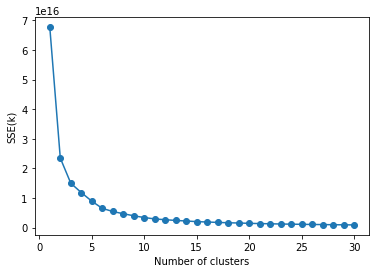

In [ ]:
kmeans_train = df_train3.drop(['target'], axis = 1)

elbow(kmeans_train)

# 7로 결정

In [ ]:
km_cao = KModes(n_clusters = 2, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(bank_cust)

In [ ]:
# 클러스터링 구성
# 타겟을 결정짓는 뚜렷한 특징을 갖는 피쳐를 찾지 못해 clustering 시도

kmeans_train = df_train3.drop(['target'], axis = 1)
kmeans = KMeans(n_clusters = 15, init = 'k-means++', n_init = 10, max_iter = 300, tol = 1e-04, random_state = 39).fit(kmeans_train)
df_train3['cluster'] = kmeans.predict(kmeans_train)
df_test3['cluster'] = kmeans.predict(df_test3)

In [ ]:
df_train3['cluster'] = df_train3['cluster'].astype('int64')
df_test3['cluster'] = df_test3['cluster'].astype('int64')

df_train3.dtypes.value_counts()

int64    93
dtype: int64

In [ ]:
df_train4 = df_train3.copy()
df_test4 = df_test3.copy()

In [ ]:
# StandardScale
# 컬럼 정규화

temp_columns2 = numerical_feats
scaler = StandardScaler()
df_train4[temp_columns2] = scaler.fit_transform(df_train4[temp_columns2])
df_test4[temp_columns2] = scaler.transform(df_test4[temp_columns2])

In [ ]:
print(df_train4.dtypes.value_counts())
print(df_test4.dtypes.value_counts())

int64      86
float64     7
dtype: int64
int64      85
float64     7
dtype: int64


In [ ]:
df_train6_1 = df_train4.loc[df_train4['Month'] < 0.7, :]
df_train6_1.reset_index(drop = True, inplace = True)
X_part_train = df_train6_1.drop('target', axis = 1)
y_part_train = df_train6_1['target']

df_train6_2 = df_train4.loc[(df_train4['Month'] > 0.7) & (df_train4['Month'] < 1.4)]
df_train6_2.reset_index(drop = True, inplace = True)
X_val = df_train6_2.drop('target', axis = 1)
y_val = df_train6_2['target']

df_train6_3 = df_train4.loc[df_train4['Month']> 1.4]
df_train6_3.reset_index(drop = True, inplace = True)
X_part_test = df_train6_3.drop('target', axis = 1)
y_part_test = df_train6_3['target']

df_train6_4 = df_train4.loc[df_train4['Month'] < 1.4]
df_train6_4.reset_index(drop = True, inplace = True)
X_train = df_train6_4.drop('target', axis = 1)
y_train = df_train6_4['target']

X_test = df_test4.copy()

print(X_part_train.shape)
print(y_part_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_part_test.shape)
print(y_part_test.shape)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(368974, 92)
(368974,)
(87998, 92)
(87998,)
(44979, 92)
(44979,)
(456972, 92)
(456972,)
(46404, 92)


In [ ]:
tt1 = X_train.columns.tolist() 
tt2 = numerical_feats
print(len(tt1))
print(len(tt2))
tt3 = []
for i in tt1 :
  if i not in tt2 :
    tt3.append(i)
print(len(tt3))
print(tt3)

cat_cols = tt3

92
7
85
['person_attribute_a', 'person_attribute_a_under', 'person_attribute_b', 'person_prefer_c', 'person_prefer_d_1', 'person_prefer_d_2', 'person_prefer_d_3', 'person_prefer_e', 'person_prefer_h_1', 'person_prefer_h_2', 'person_prefer_h_3', 'contents_attribute_i', 'contents_attribute_a', 'contents_attribute_j_under', 'contents_attribute_j', 'contents_attribute_c', 'contents_attribute_k', 'contents_attribute_l', 'contents_attribute_d', 'contents_attribute_m', 'contents_attribute_e', 'contents_attribute_h', 'person_rn', 'contents_rn', 'person_prefer_d_1_세', 'person_prefer_d_1_소', 'person_prefer_d_1_중', 'person_prefer_d_1_대', 'person_prefer_d_2_세', 'person_prefer_d_2_소', 'person_prefer_d_2_중', 'person_prefer_d_2_대', 'person_prefer_d_3_세', 'person_prefer_d_3_소', 'person_prefer_d_3_중', 'person_prefer_d_3_대', 'contents_attribute_d_세', 'contents_attribute_d_소', 'contents_attribute_d_중', 'contents_attribute_d_대', 'person_prefer_h_1_중', 'person_prefer_h_1_대', 'person_prefer_h_2_중', 'person_

In [ ]:
temp = X_part_train.columns[X_part_train.nunique() > 2].tolist()
temp2 = set(temp)
cat_cols2 = set(cat_cols)
cat_cols3 = list(temp2 & cat_cols2)
print(len(cat_cols3))

58


# 6-2. 모델링 3

In [ ]:
def tscv(model) :

    tscv_list = []
    model_name = model.__class__.__name__

    for i in range(1, 11) :

      df_train5_1 = df_train4.loc[df_train4['Month'] <= i, :]
      X_train = df_train5_1.drop('target', axis = 1)
      y_train = df_train5_1['target']
      df_train5_2 = df_train4.loc[df_train4['Month'] == i + 1]
      X_test = df_train5_2.drop('target', axis = 1)
      y_test = df_train5_2['target']

      clf = model.fit(X_train, y_train)
      pred = clf.predict(X_test)
      f1 = f1_score(y_test, pred) 
      tscv_list.append(f1)
      print(model_name, i)

    return model_name, tscv_list

In [ ]:
def print_f1_score(model) :
    # cv별 프린팅, 평균 저장
    model_name, score = tscv(model)

    for i, r in enumerate(score, start = 1) :
        print(f'{i} FOLDS: {model_name} f1 : {r:.4f}')
    print(f'\n{model_name} mean f1 : {np.mean(score):.4f}')
    print('=' * 40)
    return model_name, np.mean(score)

In [ ]:
models = []
scores = []

# [rf, model_xgb, model_lgb, etc]

for model in [rf, model_xgb, model_lgb, etc] :
    model_name, mean_score = print_f1_score(model)
    models.append(model_name)
    scores.append(mean_score)

In [ ]:
def objective(trial : Trial) -> float :

    params_cat = {
        "random_state" : 39,
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 30.00),
        "n_estimators":trial.suggest_int("n_estimators", 3000, 7000),
        "max_depth":trial.suggest_int("max_depth", 4, 16),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        'od_type': 'Iter',
        'one_hot_max_size' : trial.suggest_int('one_hot_max_size', 0, 5)
  }
    
    model = CatBoostClassifier(**params_cat, task_type = "GPU")
    model.fit(X_part_train, y_part_train, eval_set = [(X_val, y_val)],
              early_stopping_rounds = 50, cat_features = cat_cols3, verbose = False)

    cat_pred = model.predict(X_val)
    f1 = f1_score(y_val, cat_pred)
    
    return f1

In [ ]:
sampler = TPESampler(seed = 39)
study = optuna.create_study(
    study_name = "cat_parameter_opt",
    direction = "maximize",
    sampler = sampler)
study.optimize(objective, n_trials = 40)

[I 2022-01-15 15:48:25,145] A new study created in memory with name: cat_parameter_opt
Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-01-15 15:53:03,895] Trial 0 finished with value: 0.6157812482175654 and parameters: {'learning_rate': 0.012410186619312995, 'bagging_temperature': 5.948283319926105, 'n_estimators': 6282, 'max_depth': 5, 'random_strength': 60, 'max_bin': 358, 'one_hot_max_size': 2}. Best is trial 0 with value: 0.6157812482175654.
[I 2022-01-15 16:26:37,533] Trial 1 finished with value: 0.6141239816131953 and parameters: {'learning_rate': 0.008767817244598053, 'bagging_temperature': 1.5849635319969935, 'n_estimators': 6703, 'max_depth': 14, 'random_strength': 95, 'max_bin': 476, 'one_hot_max_size': 2}. Best is trial 0 with value: 0.6157812482175654.
[I 2022-01-15 16:34:19,183] Trial 2 finished with value: 0.6454432093107527 and parameters: {'learning_rate': 0.04483569690392285, 'bagging_temperature': 19.51017530620

In [ ]:
print("Best Score :", study.best_value)
print("Best trial :", study.best_trial.params)

In [ ]:
# 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# 파라미터들과의 관계
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# 하이퍼파라미터 중요도
optuna.visualization.plot_param_importances(study)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def f1_score_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출후 f1 score 도출
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    f1 =  2*(precisions*recalls)/(precisions+recalls)
    
    # X축을 threshold값으로, Y축은 f1 score으로 Plot 수행
    plt.figure(figsize=(10,8))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, f1[0:threshold_boundary], label='f1 score')
    
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim([0,1])
    plt.xticks(np.round(np.arange(start, end, 0.05),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('f1 score')
    plt.legend(); plt.grid()
    plt.grid(True)
    plt.show()
    
f1_score_curve_plot(made_test_y, cb_best.predict_proba(made_test_x)[:, 1] )